In [109]:
# imports
from src.data.utils import gedi_utils
from src.data.pipelines.extract_gedi_data import SIERRAS_GEDI_ID_COLUMNS, SEKI_GEDI_ID_COLUMNS, SIERRAS_GEDI_ALL_COLUMNS, SEKI_GEDI_ALL_COLUMNS
from src.data.gedi import gedi_loader
from src.constants import GEDI_INTERMEDIATE_PATH, INTERMEDIATE_RESULTS
from fastai.tabular.all import load_pickle, save_pickle
from src.data.processing import severity_overlay as se
from src.data.processing import raster_overlays as ro
from src.data.adapters import calfire_perimeters as cp
from src.data.pipelines import run_overlays as overlays
from src.data.adapters import mtbs
from src.data.pipelines import aggregate_analysis as aa
import numpy as np
from scipy import stats
import statsmodels.api as sm

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid", palette="Set2")
palette = sns.color_palette("Set2")

import pandas as pd

import importlib
importlib.reload(se)
importlib.reload(ro)
importlib.reload(gedi_utils)
importlib.reload(aa)

2024-01-24 04:01:32,385 DEBUG: Logger /home/jk871/fire-regen/src/data/processing/severity_overlay.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]
2024-01-24 04:01:32,387 DEBUG: Logger /home/jk871/fire-regen/src/data/processing/raster_overlays.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]


<module 'src.data.pipelines.aggregate_analysis' from '/home/jk871/fire-regen/src/data/pipelines/aggregate_analysis.py'>

# Analysis of Severity Effects

This notebook is similar to DataDependencies notebook, analyzing how the data looks like when it's stratified according to the burn severity.

### Data PreProcessing

In [3]:
def get_overlays_path(file_name: str):
    return f"{aa.OVERLAYS_PATH}/{file_name}"

def get_pipelines_path(file_name: str):
    return f"{aa.PIPELINES_PATH}/{file_name}"

In [4]:
df_in = load_pickle(get_pipelines_path("severity_aggregated_info.pkl"))

In [5]:
unburned = df_in[df_in.fire_id.isna()]
burned = df_in[(df_in.fire_id.notna())]

In [6]:
df_in.loc[unburned.index, "pre_fire_ndvi"] = unburned.ndvi

In [8]:
df = df_in[(df_in.YSF != 0) & (df_in.YSF < 36)]

In [9]:
df["ndvi_ratio"] = df["ndvi"] / df["pre_fire_ndvi"]
burned = df[df.YSF > 0]
unburned = df[df.YSF < 0]

In [12]:
burned = mtbs.get_burn_severity(burned)

## SFT Plots

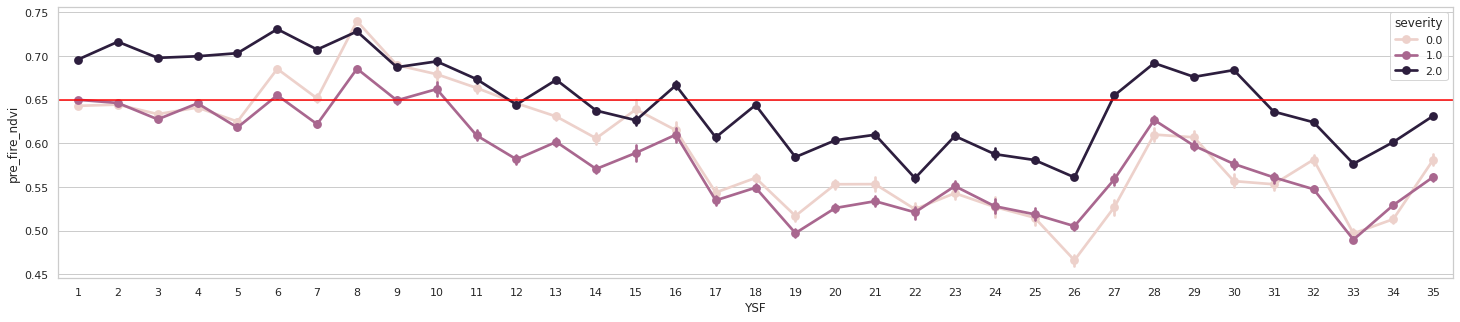

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(25, 5))
sns.pointplot(burned, x="YSF", y="pre_fire_ndvi", ax=ax, hue="severity")
ax.axhline(unburned.ndvi.mean(), color="red")

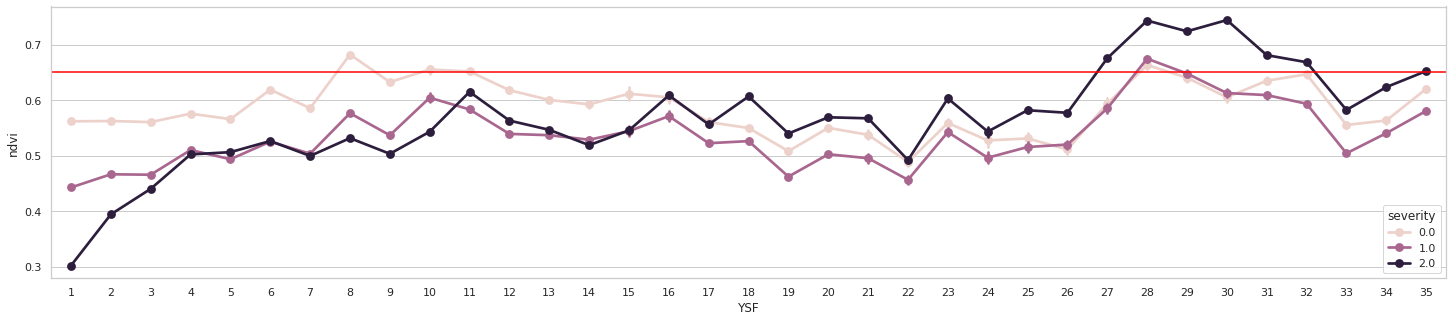

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(25, 5))
sns.pointplot(burned, x="YSF", y="ndvi", ax=ax, hue="severity")
ax.axhline(unburned.ndvi.mean(), color="red")

<AxesSubplot: xlabel='YSF', ylabel='ndvi_ratio'>

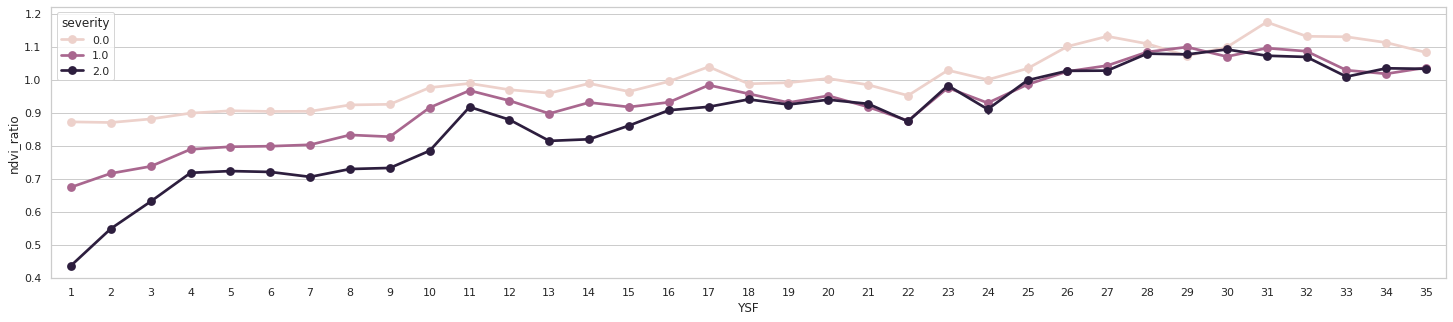

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(25, 5))
sns.pointplot(burned, x="YSF", y="ndvi_ratio", ax=ax, hue="severity")

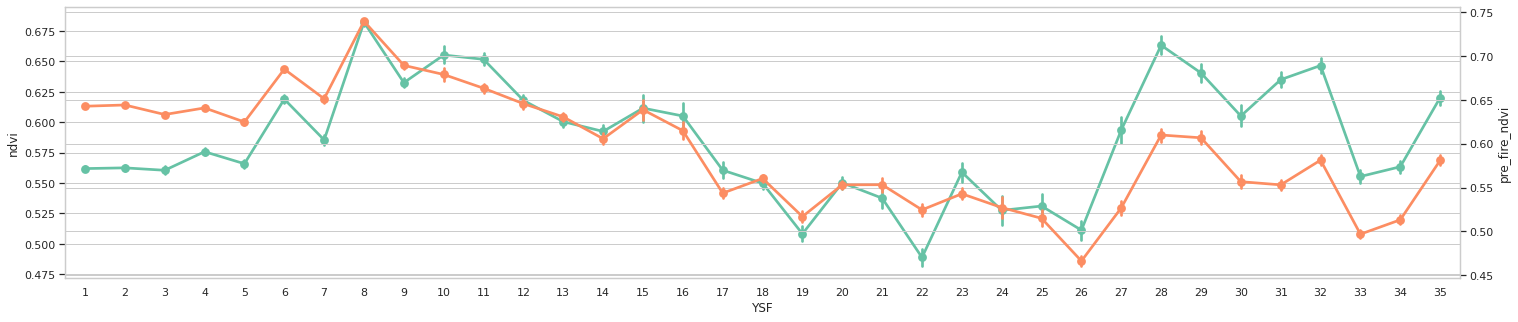

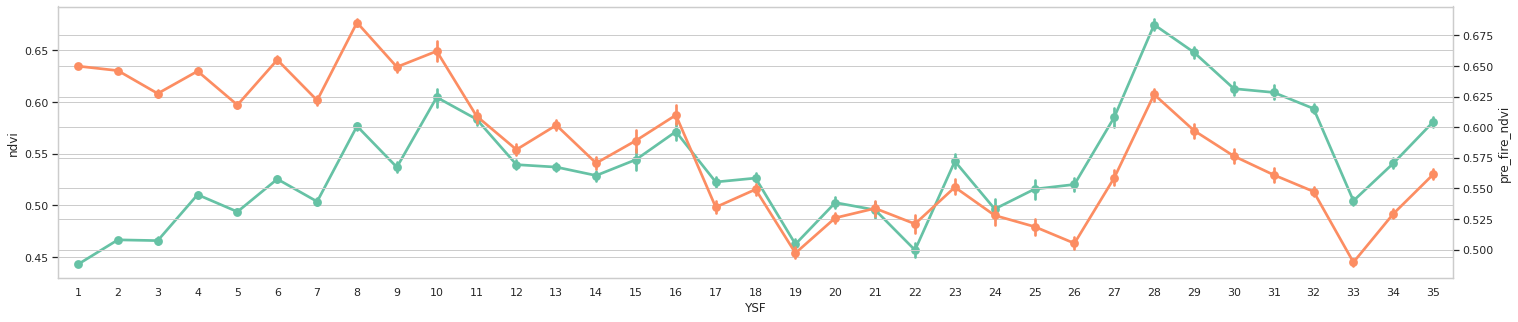

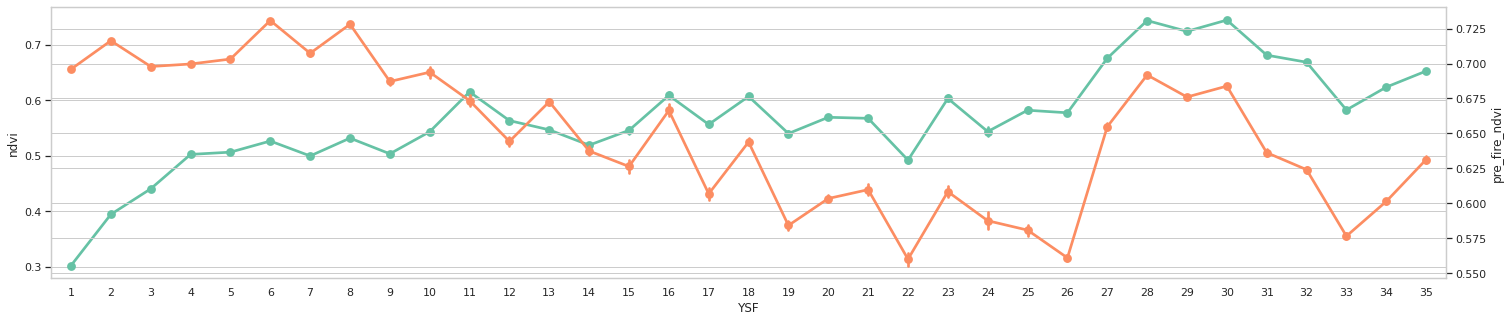

In [21]:
for severity in range(0, 3):
    fig, ax = plt.subplots(1, 1, figsize=(25, 5))
    ax2 = ax.twinx()
    dft = burned[burned.severity == severity]
    sns.pointplot(dft, x="YSF", y="ndvi", ax=ax)
    sns.pointplot(dft, x="YSF", y="pre_fire_ndvi", ax=ax2, color=palette[1])

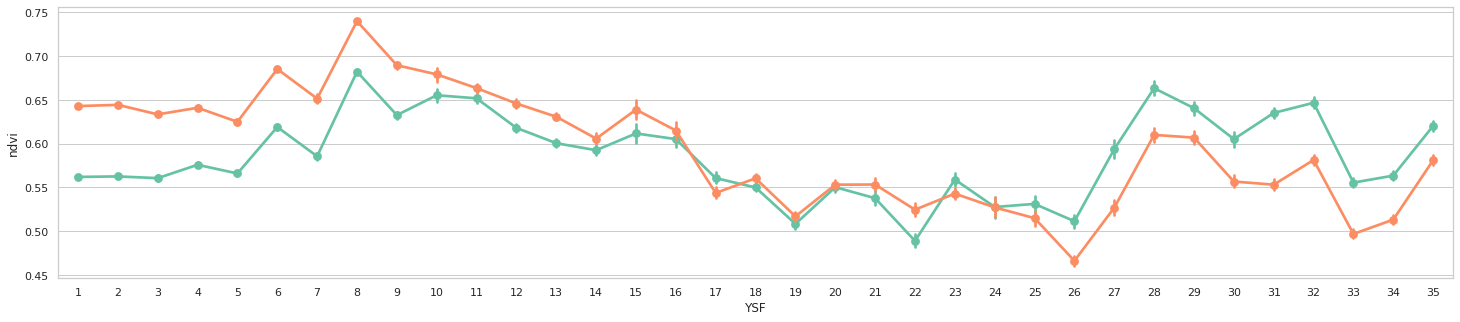

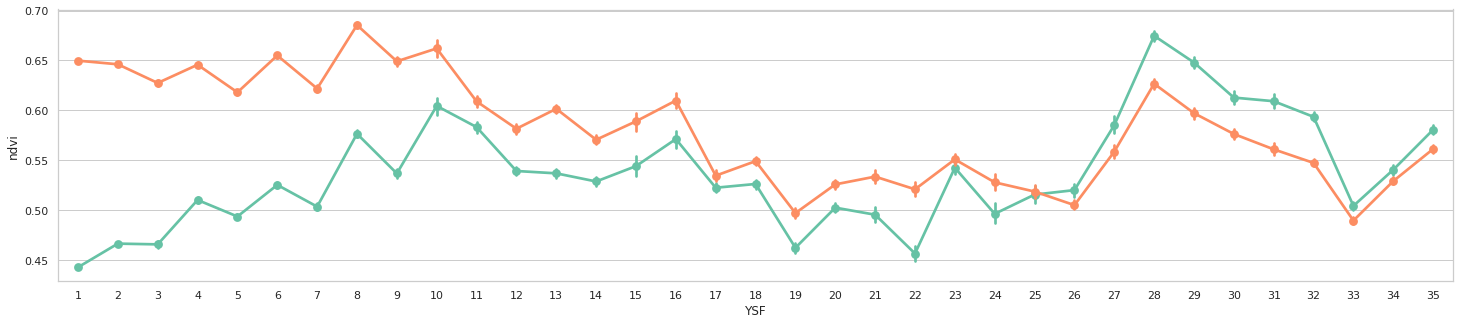

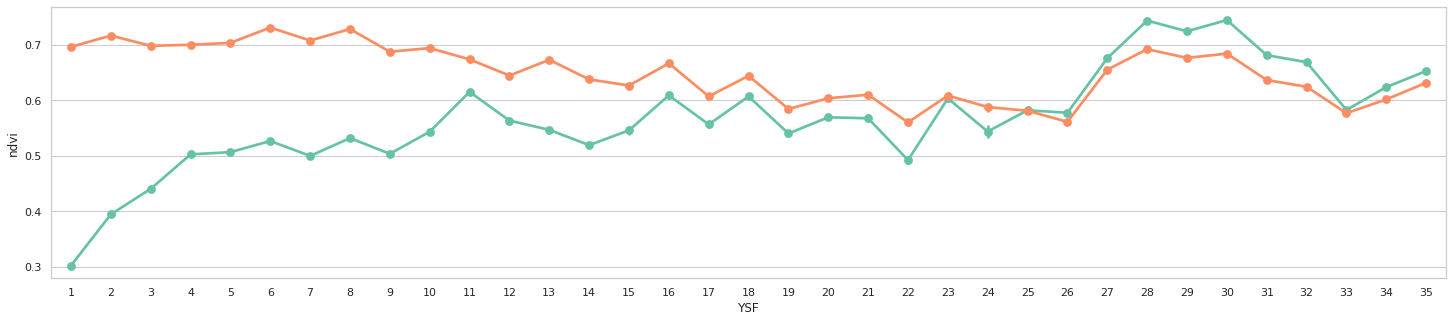

In [22]:
for severity in range(0, 3):
    fig, ax = plt.subplots(1, 1, figsize=(25, 5))
    dft = burned[burned.severity == severity]
    sns.pointplot(dft, x="YSF", y="ndvi", ax=ax)
    sns.pointplot(dft, x="YSF", y="pre_fire_ndvi", ax=ax, color=palette[1])

The gap between NDVI values for each severity is different in the beginning, with high-severity experiencing the largest gap and the longest time to recover. In the last 10 years,NDVI values exceed pre-fire values for each severity.

The graph above this one, where we use a twin axis, to only capture a shape of curves and their relationship, show the largest difference in high-severity group - where the NDVI trajectory is predominantly upwards reflecting recovery, and where recovery forces are much stronger than just the trends that reflect pre-fire values, vs in low severity where the gap between the series is much smaller.

## GEDI metrics

The following two graphs "compare" pre-fire NDVI with RH 98 and PAI - but when we say compare we really just compare the shapes of the curves, as the values are not comparable. We see that for the low-severity burns, the two curves follow each other almost perfectly, and moderate burns are slightly diffferent. Which makes me think that GEDI metrics are mostly reflecting pre-fire vegetation, rather than showing recovery. For high-severity though, the gap between pre-fire ndvi and GEDI is huge in the first 15 years, and it decreases - even superseeding pre-fire values. Again, this is not really a comparison, just intuitive observation of curve shapes.

Even in high-severity case we see a huge jump in both metrics 26-27 years transition, showing how much pre-fire NDVI values influence the SFT numbers we're getting. A LOT.

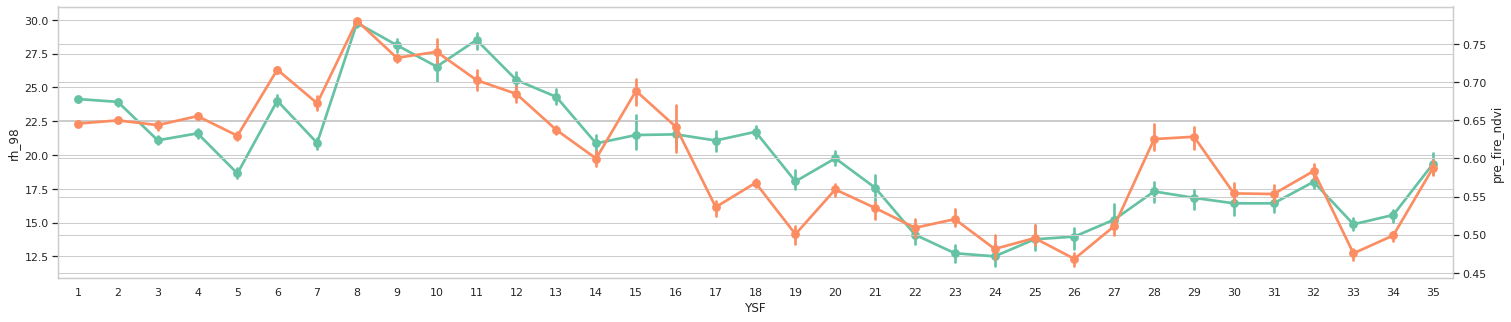

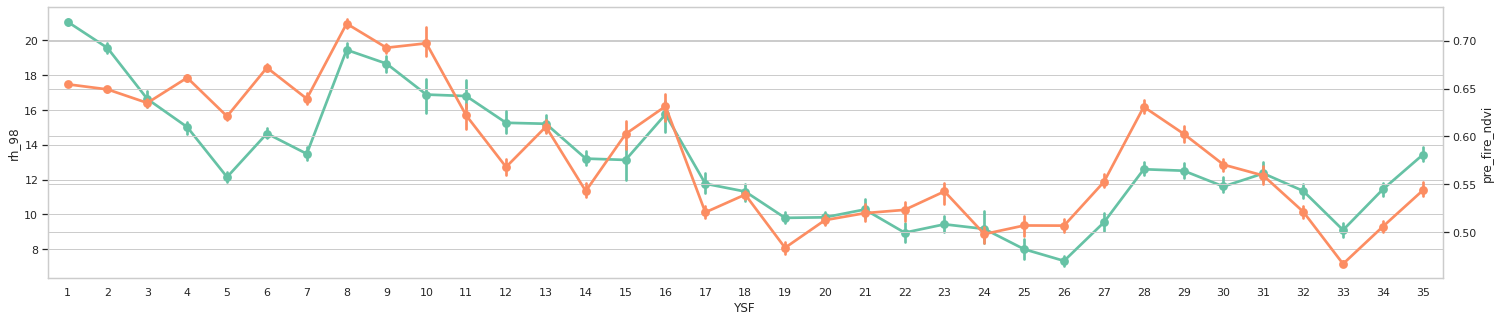

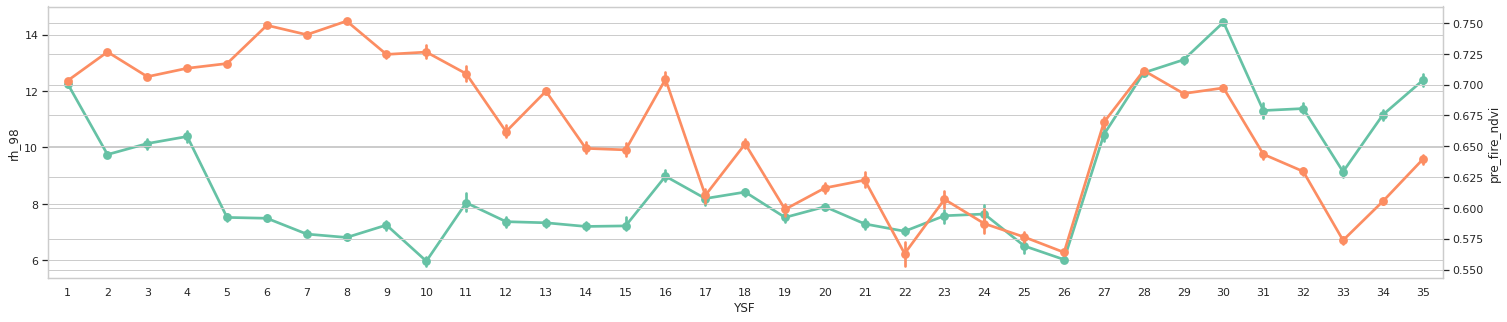

In [19]:
for severity in range(0, 3):
    fig, ax = plt.subplots(1, 1, figsize=(25, 5))
    ax2 = ax.twinx()
    dft = burned[burned.severity == severity]
    sns.pointplot(dft, x="YSF", y="rh_98", ax=ax, estimator="median")
    sns.pointplot(dft, x="YSF", y="pre_fire_ndvi", ax=ax2, color=palette[1], estimator="median")

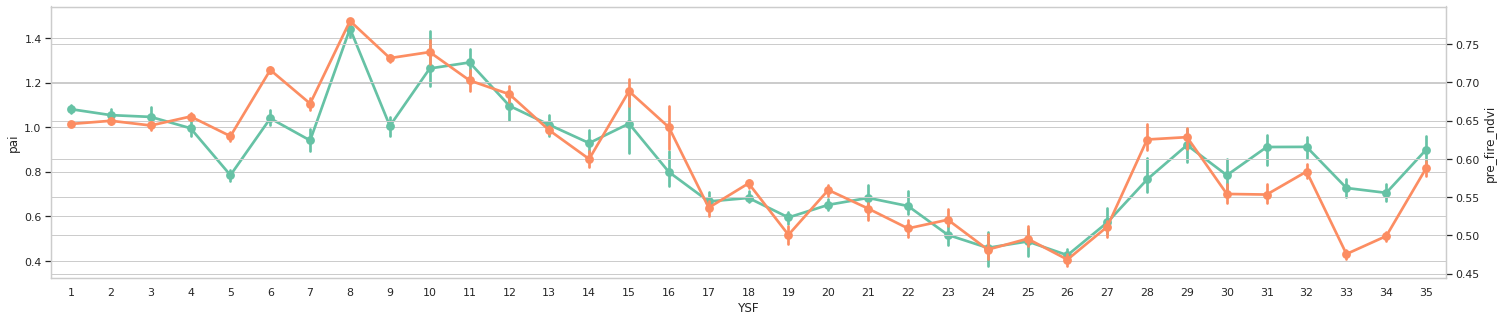

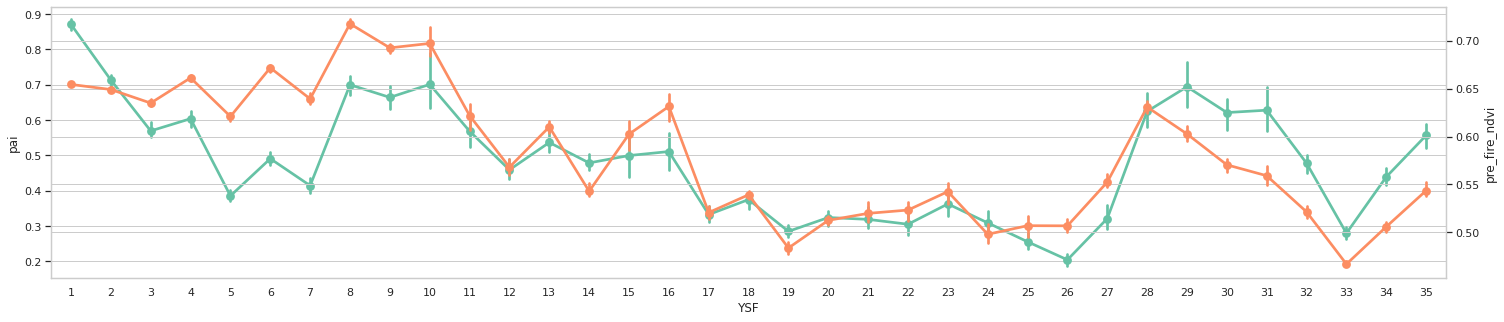

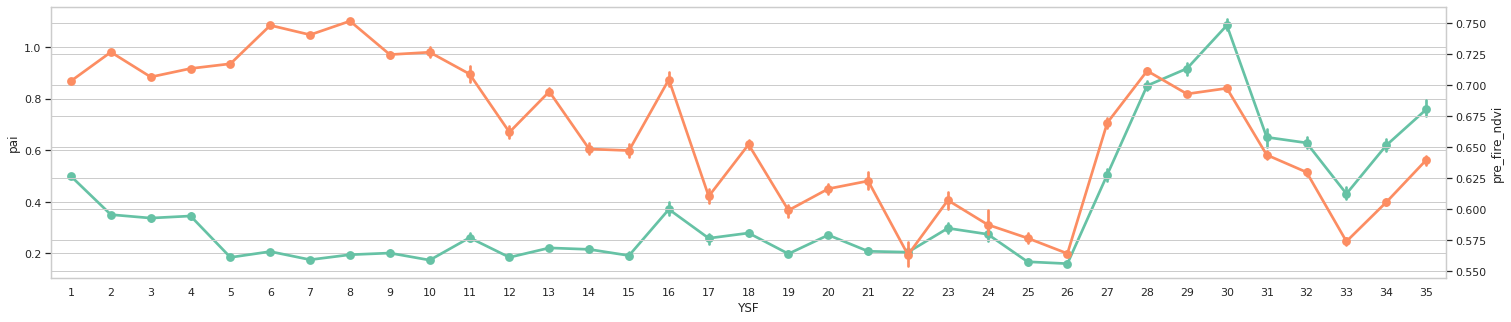

In [23]:
for severity in range(0, 3):
    fig, ax = plt.subplots(1, 1, figsize=(25, 5))
    ax2 = ax.twinx()
    dft = burned[burned.severity == severity]
    sns.pointplot(dft, x="YSF", y="pai", ax=ax, estimator="median")
    sns.pointplot(dft, x="YSF", y="pre_fire_ndvi", ax=ax2, color=palette[1], estimator="median")

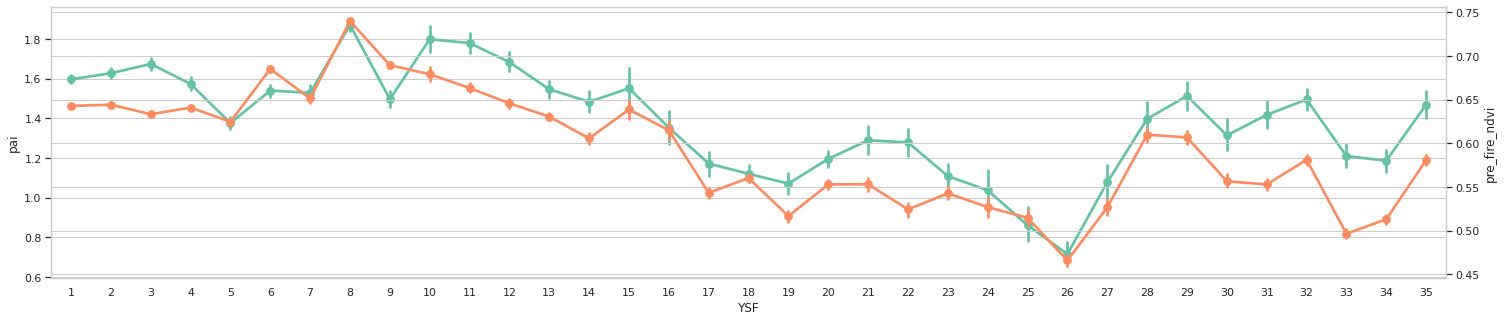

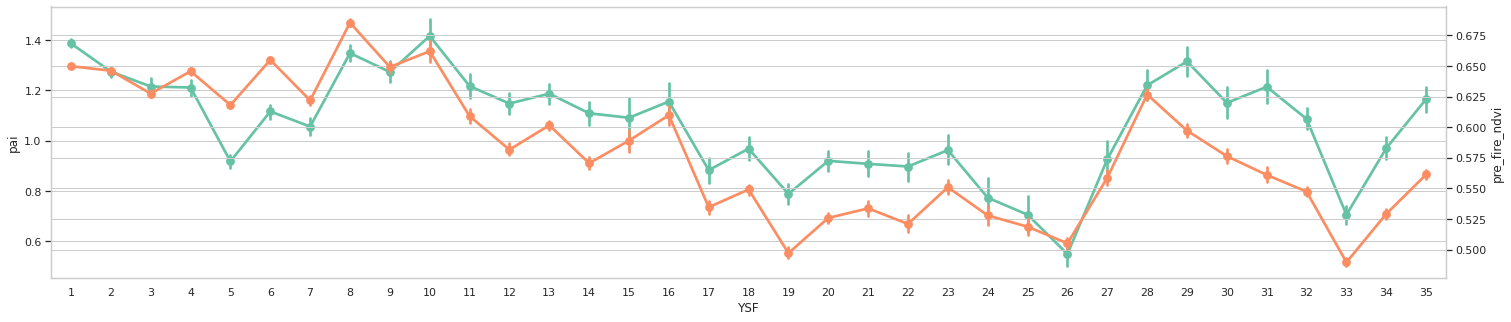

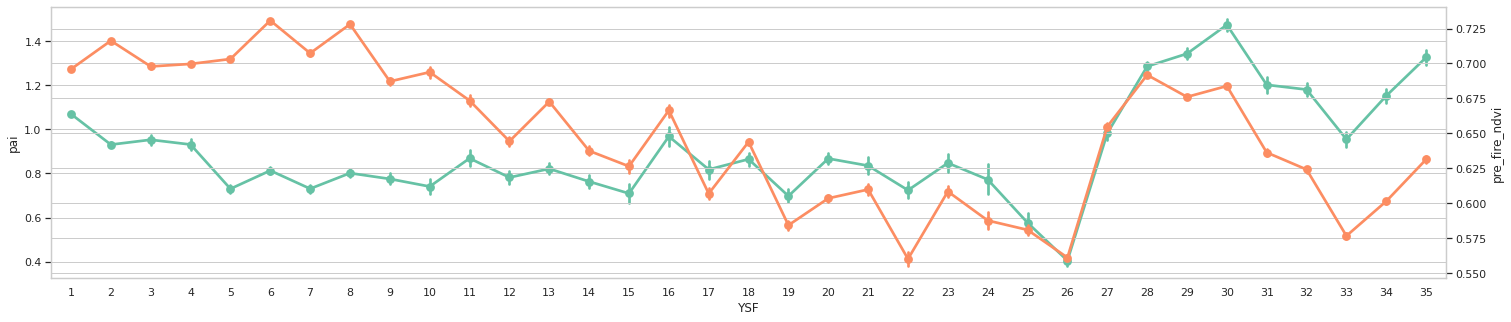

In [24]:
for severity in range(0, 3):
    fig, ax = plt.subplots(1, 1, figsize=(25, 5))
    ax2 = ax.twinx()
    dft = burned[burned.severity == severity]
    sns.pointplot(dft, x="YSF", y="pai", ax=ax)
    sns.pointplot(dft, x="YSF", y="pre_fire_ndvi", ax=ax2, color=palette[1])

Observe also that mean and median are "very" different - median is probably the more correct thing to use given the wide spread and outliers, but it takes longer to compute for some reason.

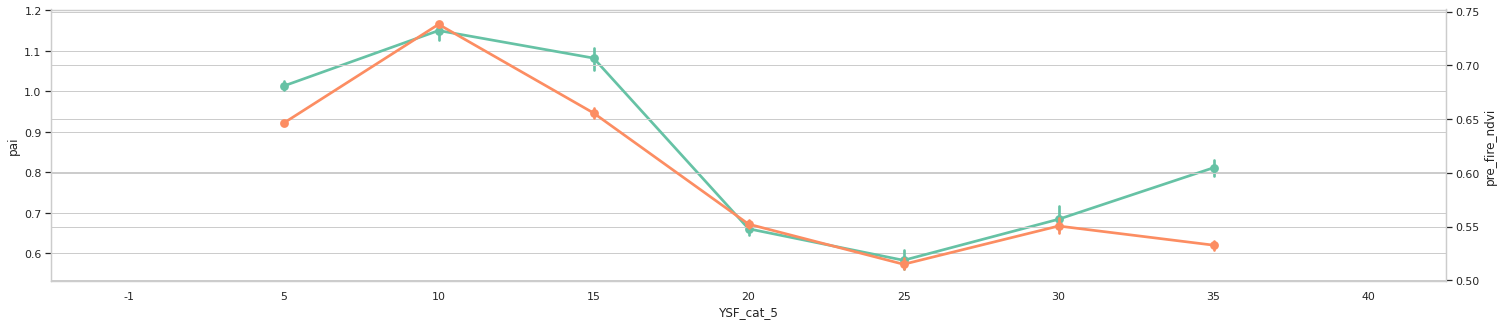

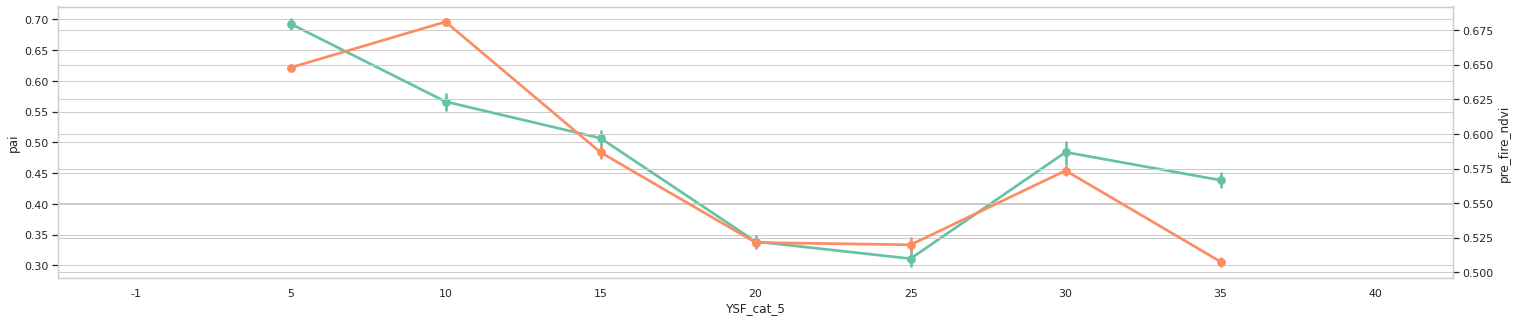

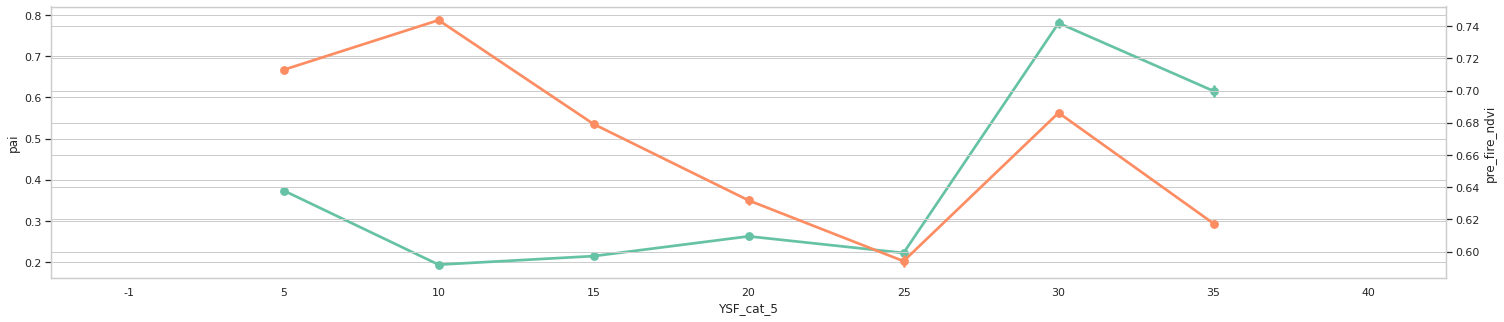

In [25]:
for severity in range(0, 3):
    fig, ax = plt.subplots(1, 1, figsize=(25, 5))
    ax2 = ax.twinx()
    dft = burned[burned.severity == severity]
    sns.pointplot(dft, x="YSF_cat_5", y="pai", ax=ax, estimator="median")
    sns.pointplot(dft, x="YSF_cat_5", y="pre_fire_ndvi", ax=ax2, color=palette[1], estimator="median")

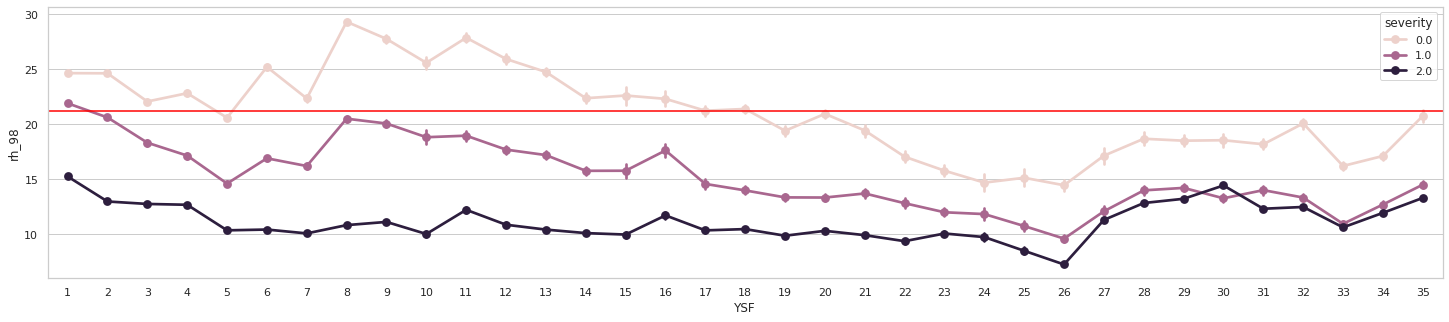

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(25, 5))
sns.pointplot(burned, x="YSF", y="rh_98", ax=ax, hue="severity")
ax.axhline(unburned.rh_98.mean(), color="red")

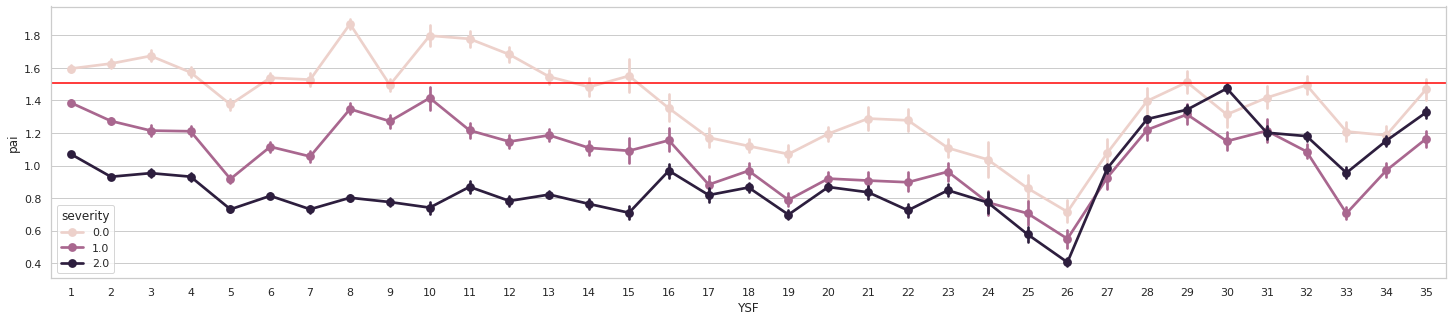

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(25, 5))
sns.pointplot(burned, x="YSF", y="pai", ax=ax, hue="severity")
ax.axhline(unburned.pai.mean(), color="red")

### Look at 5 year buckets

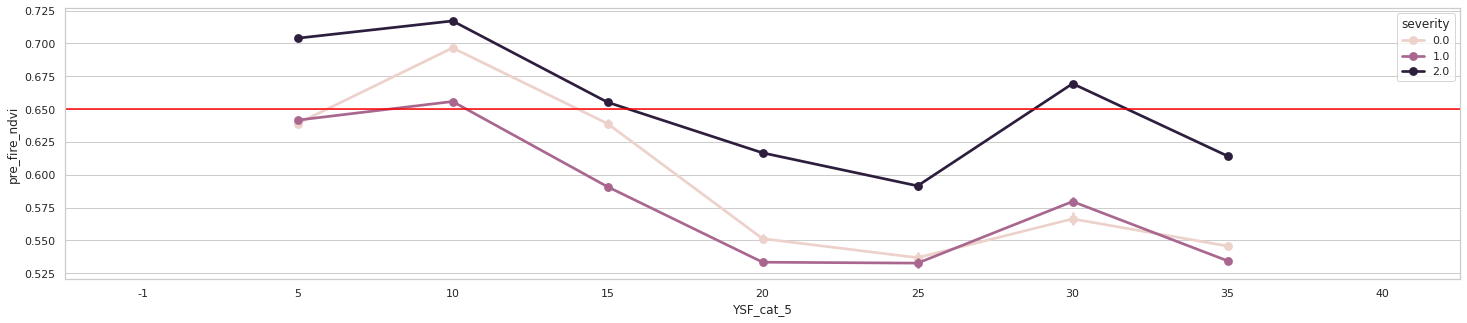

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(25, 5))
sns.pointplot(burned, x="YSF_cat_5", y="pre_fire_ndvi", ax=ax, hue="severity")
ax.axhline(unburned.ndvi.mean(), color="red")

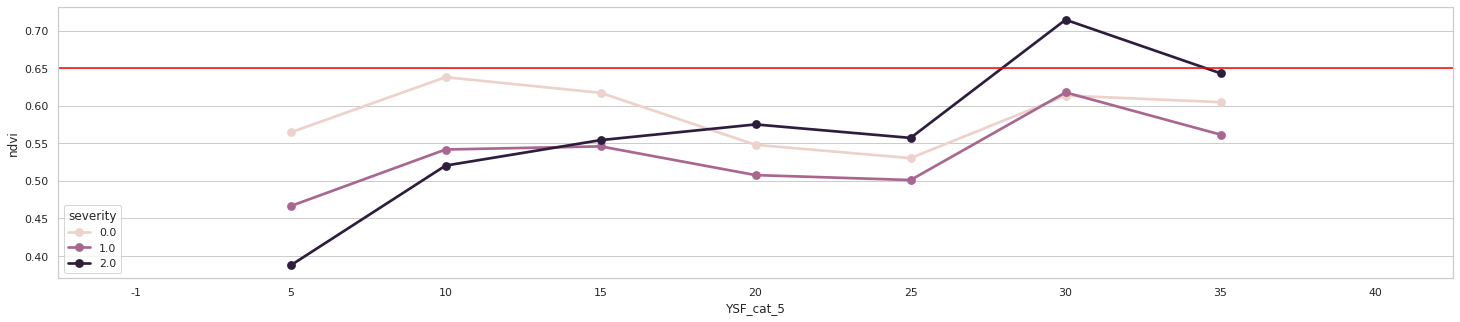

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(25, 5))
sns.pointplot(burned, x="YSF_cat_5", y="ndvi", ax=ax, hue="severity")
ax.axhline(unburned.ndvi.mean(), color="red")

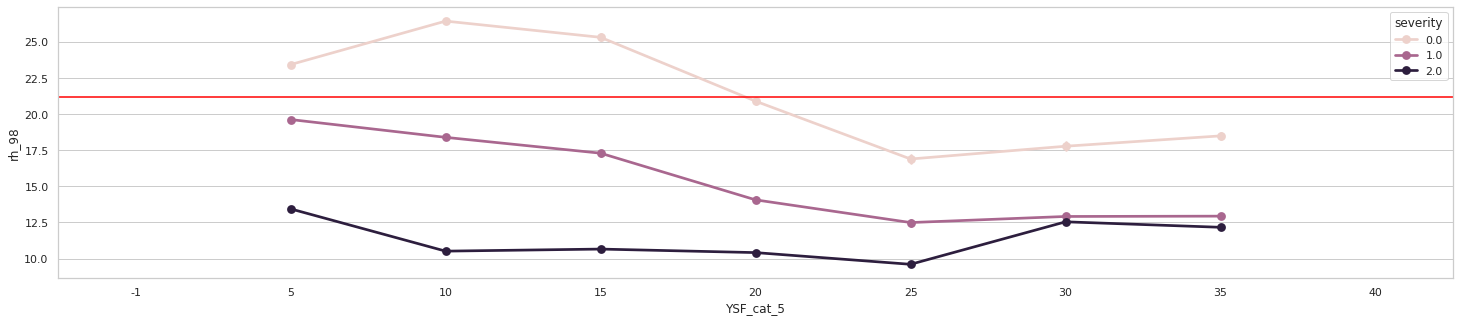

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(25, 5))
sns.pointplot(burned, x="YSF_cat_5", y="rh_98", ax=ax, hue="severity")
ax.axhline(unburned.rh_98.mean(), color="red")

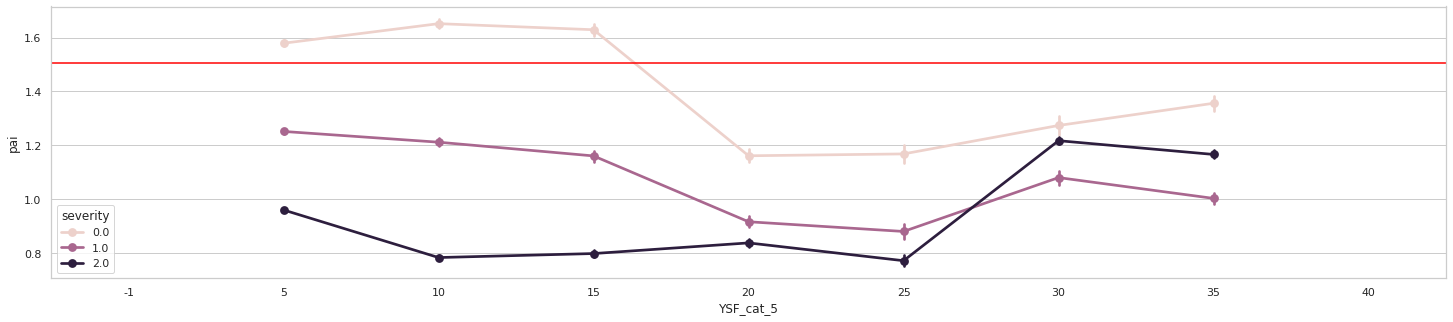

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(25, 5))
sns.pointplot(burned, x="YSF_cat_5", y="pai", ax=ax, hue="severity")
ax.axhline(unburned.pai.mean(), color="red")

Observations:
1. There is a clear separation of severities in GEDI metrics, which is very good to see. Means that severity of fires does impact long-term structure.
2. Low severity RH98 is much more separate in later recovery years from PAI, which means that likely fire is differently impacting different GEDI metrics long term.

### Density plots

In [ ]:
low_c = sns.color_palette("rocket")[5]
mod_c = sns.color_palette("rocket")[3]
high_c = sns.color_palette("rocket")[0]

: 

In [46]:
def kde_severity(data_frame, metric, severity, ax):
    dft = data_frame[data_frame.severity == severity]
    if severity == 0:
        color = low_c
    elif severity == 1:
        color = mod_c
    else:
        color = high_c
    sns.kdeplot(dft, x=metric, ax=ax, color=color)


In [58]:
def kde_before_after(metric, before, after):
    fig, ax = plt.subplots(1, 2, figsize=(25, 7))
    sns.kdeplot(unburned, x=metric, ax=ax[0], color="gray", linestyle="--")
    sns.kdeplot(unburned, x=metric, ax=ax[1], color="gray", linestyle="--")

    dft = burned[burned.YSF_cat_5 == before]
    for severity in [0, 1, 2]:
        kde_severity(dft, metric, severity, ax[0])


    dft = burned[burned.YSF_cat_5 == after]
    for severity in [0, 1, 2]:
        kde_severity(dft, metric, severity, ax[1])


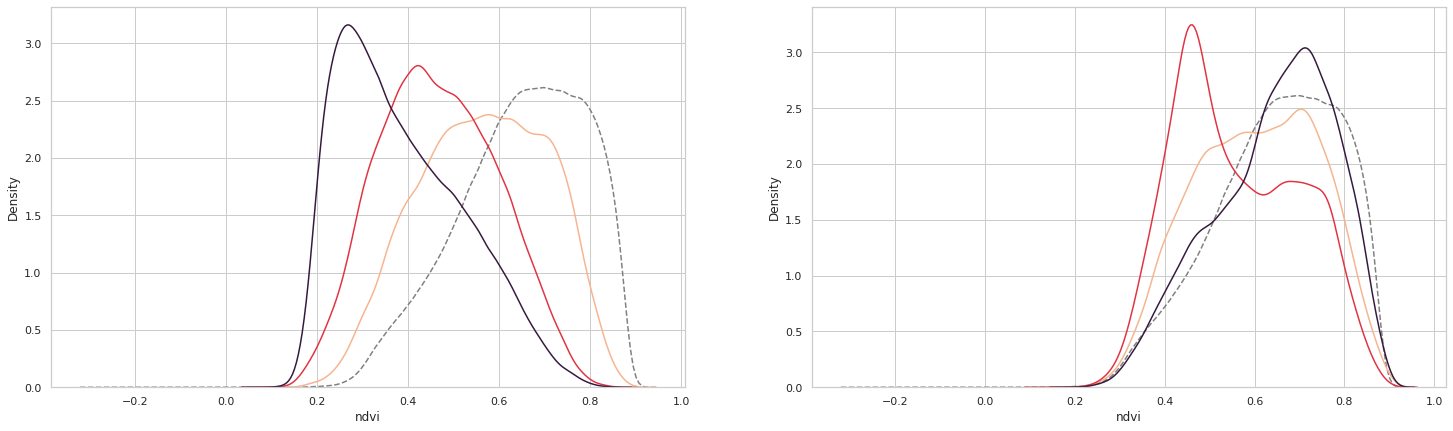

In [65]:
kde_before_after("ndvi", 5, 35)

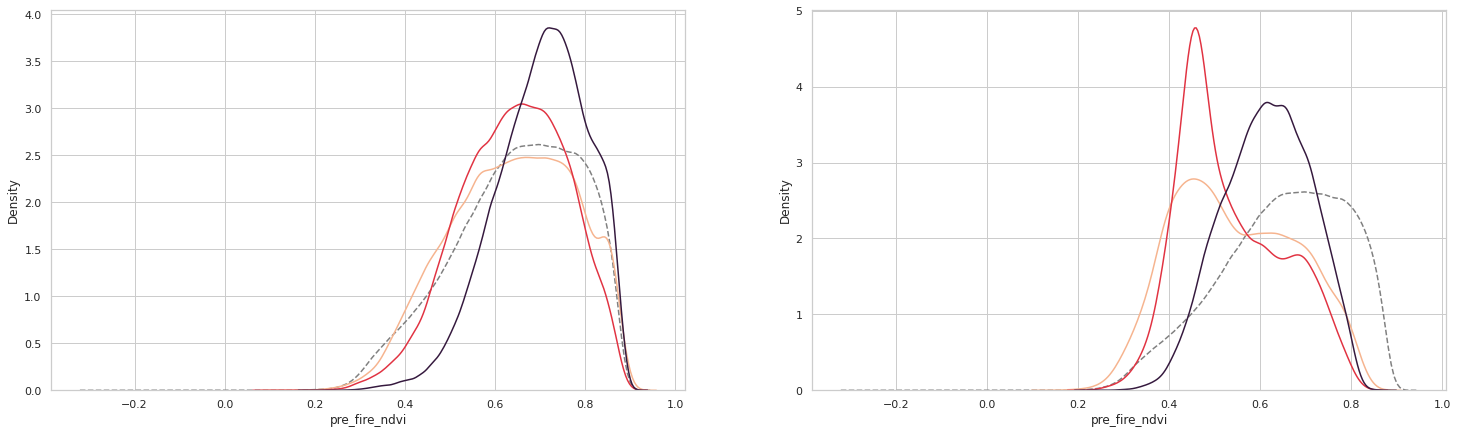

In [64]:
kde_before_after("pre_fire_ndvi", 5, 35)

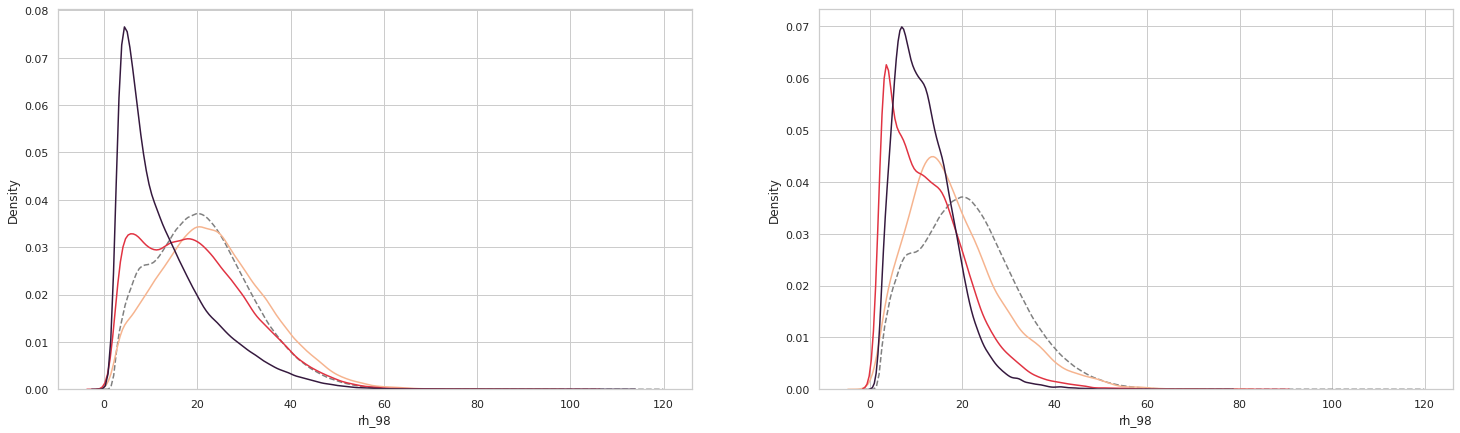

In [63]:
kde_before_after("rh_98", 5, 35)

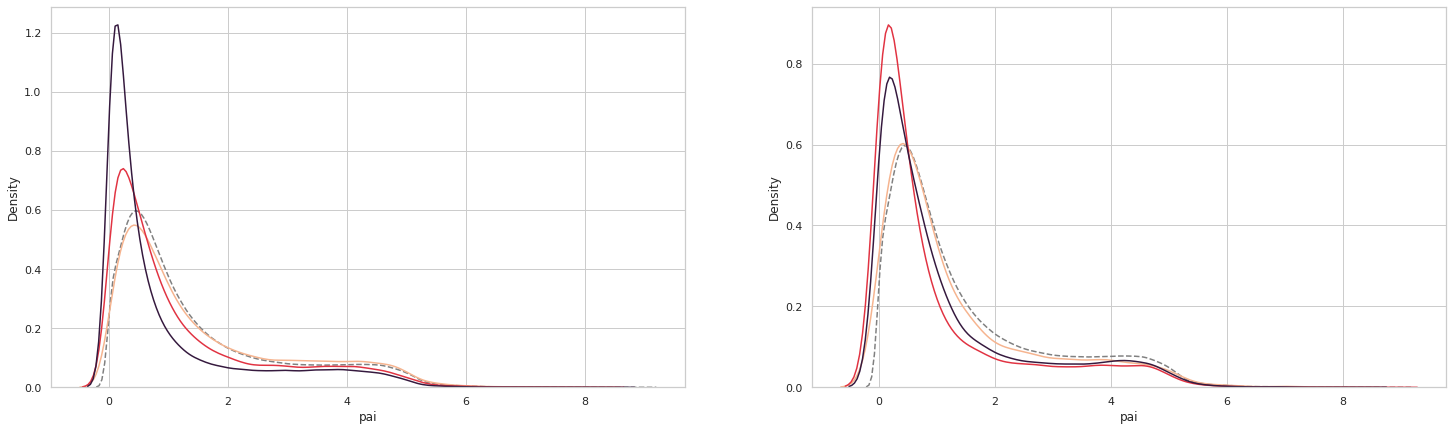

In [62]:
kde_before_after("pai", 5, 35)

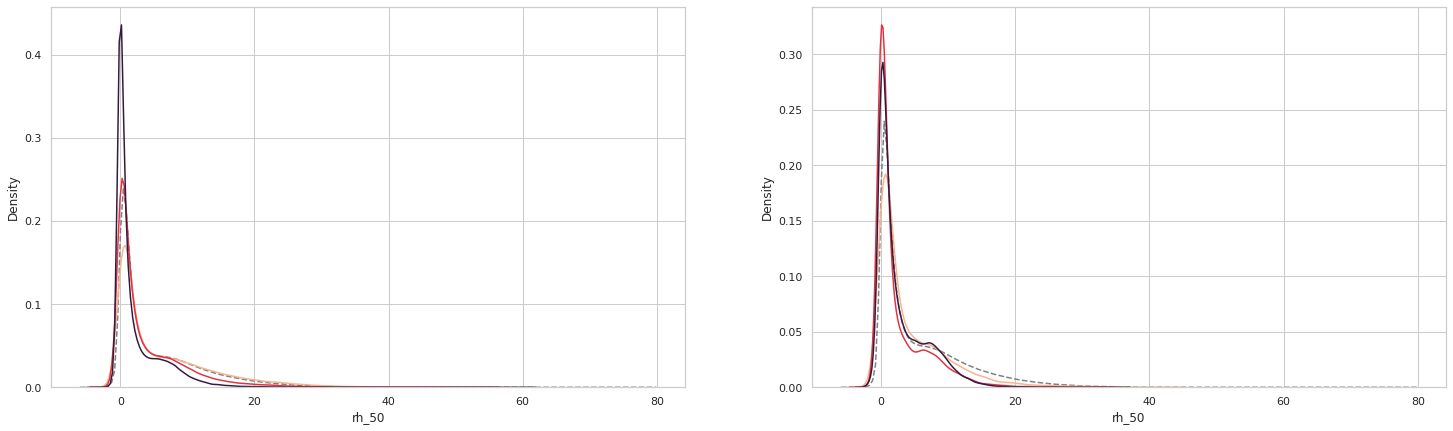

In [61]:
kde_before_after("rh_50", 5, 35)

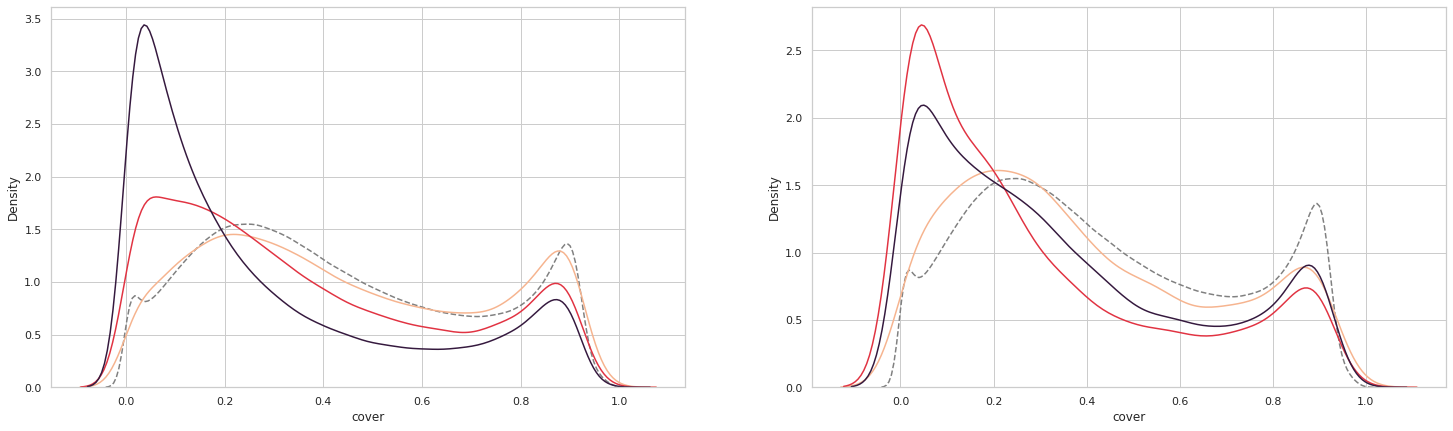

In [60]:
kde_before_after("cover", 5, 35)

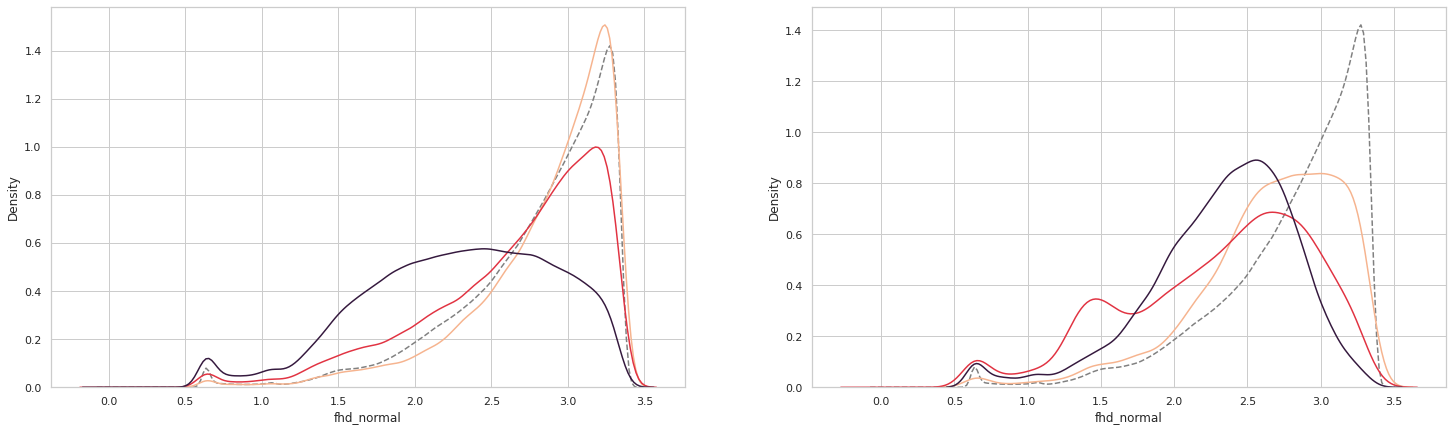

In [59]:
kde_before_after("fhd_normal", 5, 35)

## Correlations

In [69]:
columns = [
 'fire_size_acres',
 'pre_fire_ndvi',
 'YSF',
 'YSF_cat_5',
 'agbd',
 'cover',
 'fhd_normal',
 'latitude',
 'longitude',
 'pai',
 'rh_25',
 'rh_50',
 'rh_70',
 'rh_98',
 'aspect',
 'elevation',
 'slope',
 'soil',
 'ndvi',
 'cover']

### Low severity

In [76]:
# look at high-severity only
correlations_burned = burned[burned.severity ==0][columns + ["ndvi_ratio"]].corr()
correlations_unburned = unburned[columns].corr()
correlations_burned.pre_fire_ndvi

fire_size_acres    0.073212
pre_fire_ndvi      1.000000
YSF               -0.253058
YSF_cat_5         -0.251046
agbd               0.514591
cover              0.496159
fhd_normal         0.471189
latitude           0.100577
longitude         -0.239102
pai                0.426410
rh_25              0.440027
rh_50              0.537646
rh_70              0.582059
rh_98              0.564555
aspect             0.030728
elevation         -0.183449
slope              0.175953
soil              -0.161077
ndvi               0.849856
cover              0.496159
ndvi_ratio        -0.227757
Name: pre_fire_ndvi, dtype: float64

*GEDI ~ Pre-fire NDVI*
    
    All GEDI metrics are correlated with pre-fire NDVI very strongly (0.4-0.6) for low severity burns, which means that SFT analysis for low severity can be VERY influenced by pre-fire NDVI heterogeneity in SFT samples

### High Severity

In [77]:
# look at high-severity only
correlations_burned = burned[burned.severity == 2][columns + ["ndvi_ratio"]].corr()
correlations_unburned = unburned[columns].corr()

In [71]:
correlations_burned.pre_fire_ndvi, correlations_unburned.pre_fire_ndvi

(fire_size_acres    0.122274
 pre_fire_ndvi      1.000000
 YSF               -0.263271
 YSF_cat_5         -0.262348
 agbd               0.249958
 cover              0.238936
 fhd_normal         0.260948
 latitude           0.188602
 longitude         -0.356689
 pai                0.200136
 rh_25              0.196085
 rh_50              0.233524
 rh_70              0.256844
 rh_98              0.285380
 aspect             0.054197
 elevation         -0.310427
 slope              0.119093
 soil              -0.233098
 ndvi               0.317615
 cover              0.238936
 ndvi_ratio        -0.192764
 Name: pre_fire_ndvi, dtype: float64,
 fire_size_acres         NaN
 pre_fire_ndvi      1.000000
 YSF                     NaN
 YSF_cat_5               NaN
 agbd               0.485285
 cover              0.495780
 fhd_normal         0.449959
 latitude           0.209385
 longitude         -0.450837
 pai                0.426531
 rh_25              0.441241
 rh_50              0.521822
 rh_7

In [72]:
correlations_burned.ndvi_ratio

fire_size_acres   -0.521876
pre_fire_ndvi     -0.192764
YSF                0.770713
YSF_cat_5          0.751997
agbd               0.037809
cover              0.111712
fhd_normal         0.091254
latitude           0.042424
longitude         -0.083921
pai                0.087621
rh_25              0.065087
rh_50              0.108499
rh_70              0.104546
rh_98              0.024588
aspect             0.019911
elevation         -0.178779
slope             -0.014379
soil               0.057868
ndvi               0.856825
cover              0.111712
ndvi_ratio         1.000000
Name: ndvi_ratio, dtype: float64

*GEDI ~ Pre-fire NDVI*
    
    Much weaker correlation between GEDI metrics and pre-fire NDVI, which explains why we're seeing such different trends for high-severity burns.

In [73]:
correlations_burned.rh_70, correlations_unburned.rh_70

(fire_size_acres   -0.002088
 pre_fire_ndvi      0.256844
 YSF                0.053425
 YSF_cat_5          0.057495
 agbd               0.908074
 cover              0.819114
 fhd_normal         0.635335
 latitude          -0.019507
 longitude         -0.065805
 pai                0.779563
 rh_25              0.792265
 rh_50              0.919535
 rh_70              1.000000
 rh_98              0.783869
 aspect             0.021493
 elevation         -0.156529
 slope              0.277506
 soil              -0.031861
 ndvi               0.234664
 cover              0.819114
 ndvi_ratio         0.104546
 Name: rh_70, dtype: float64,
 fire_size_acres         NaN
 pre_fire_ndvi      0.550265
 YSF                     NaN
 YSF_cat_5               NaN
 agbd               0.945308
 cover              0.784108
 fhd_normal         0.606483
 latitude           0.071141
 longitude         -0.203577
 pai                0.719698
 rh_25              0.751149
 rh_50              0.912719
 rh_70       

In [74]:
correlations_burned.pai, correlations_unburned.pai

(fire_size_acres   -0.011491
 pre_fire_ndvi      0.200136
 YSF                0.060343
 YSF_cat_5          0.062628
 agbd               0.601342
 cover              0.959042
 fhd_normal         0.507388
 latitude          -0.020417
 longitude         -0.061138
 pai                1.000000
 rh_25              0.956321
 rh_50              0.891688
 rh_70              0.779563
 rh_98              0.555666
 aspect             0.023651
 elevation         -0.168164
 slope              0.271815
 soil              -0.041194
 ndvi               0.190008
 cover              0.959042
 ndvi_ratio         0.087621
 Name: pai, dtype: float64,
 fire_size_acres         NaN
 pre_fire_ndvi      0.426531
 YSF                     NaN
 YSF_cat_5               NaN
 agbd               0.619544
 cover              0.950734
 fhd_normal         0.387365
 latitude           0.021248
 longitude         -0.154600
 pai                1.000000
 rh_25              0.894116
 rh_50              0.803773
 rh_70         

In [75]:
correlations_burned.YSF, correlations_burned.YSF_cat_5

(fire_size_acres   -0.445778
 pre_fire_ndvi     -0.263271
 YSF                1.000000
 YSF_cat_5          0.992665
 agbd              -0.027309
 cover              0.083568
 fhd_normal         0.029519
 latitude           0.122059
 longitude         -0.142994
 pai                0.060343
 rh_25              0.043176
 rh_50              0.068241
 rh_70              0.053425
 rh_98             -0.053615
 aspect             0.016205
 elevation         -0.160266
 slope             -0.092334
 soil               0.107150
 ndvi               0.598495
 cover              0.083568
 ndvi_ratio         0.770713
 Name: YSF, dtype: float64,
 fire_size_acres   -0.416370
 pre_fire_ndvi     -0.262348
 YSF                0.992665
 YSF_cat_5          1.000000
 agbd              -0.022680
 cover              0.087109
 fhd_normal         0.034815
 latitude           0.123039
 longitude         -0.140215
 pai                0.062628
 rh_25              0.045959
 rh_50              0.070729
 rh_70         

*YSF ~ vegetation metrics*

    Huge correlation with ndvi ratio (0.77) and ndvi (0.6), but no correlation with GEDI metrics.

## Plot Correlations

### High severity

In [86]:
dfp = burned[burned.severity == 2]

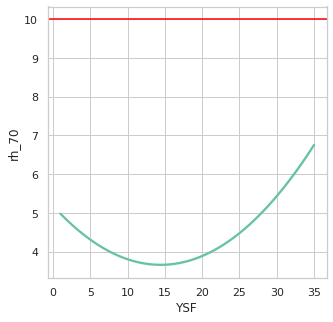

In [91]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.regplot(dfp, x="YSF", y="rh_70", scatter=False, order=2)
ax.axhline(unburned.rh_70.mean(), color="red")

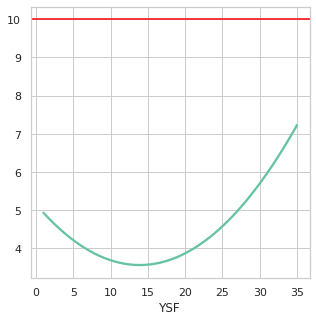

In [90]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.regplot(dfp, x="YSF", y="rh_70", scatter=False, y_partial="slope", order=2)
ax.axhline(unburned.rh_70.mean(), color="red")

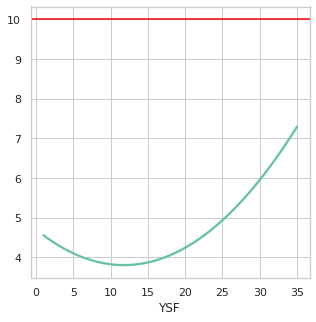

In [87]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.regplot(dfp, x="YSF", y="rh_70", scatter=False, y_partial="pre_fire_ndvi", order=2)
ax.axhline(unburned.rh_70.mean(), color="red")

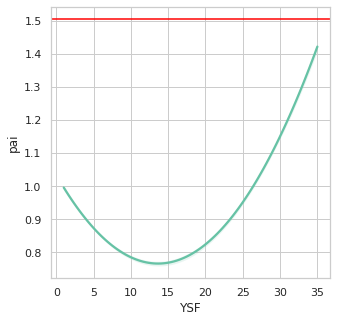

In [92]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.regplot(dfp, x="YSF", y="pai", scatter=False, order=2)
ax.axhline(unburned.pai.mean(), color="red")

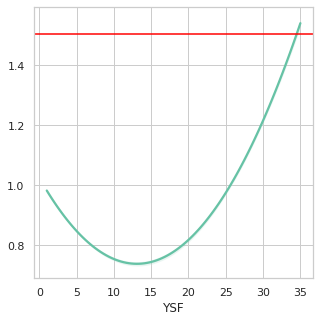

In [88]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.regplot(dfp, x="YSF", y="pai", scatter=False, y_partial="slope", order=2)
ax.axhline(unburned.pai.mean(), color="red")

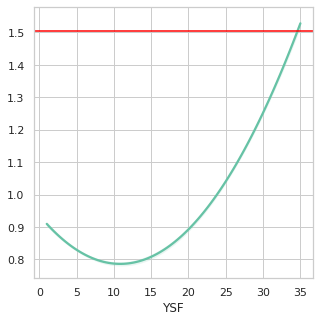

In [89]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.regplot(dfp, x="YSF", y="pai", scatter=False, y_partial="pre_fire_ndvi", order=2)
ax.axhline(unburned.pai.mean(), color="red")

### Low severity

In [96]:
dfp = burned[burned.severity == 0]

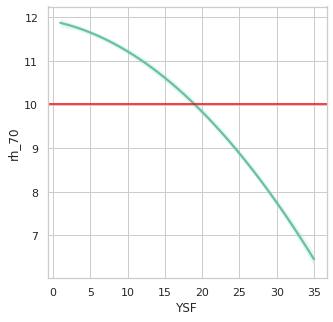

In [97]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.regplot(dfp, x="YSF", y="rh_70", scatter=False, order=2)
ax.axhline(unburned.rh_70.mean(), color="red")

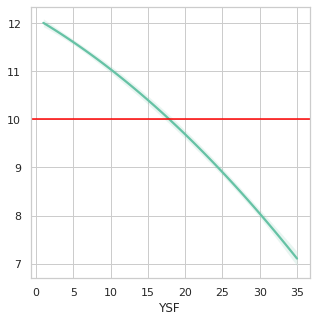

In [98]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.regplot(dfp, x="YSF", y="rh_70", scatter=False, y_partial="slope", order=2)
ax.axhline(unburned.rh_70.mean(), color="red")

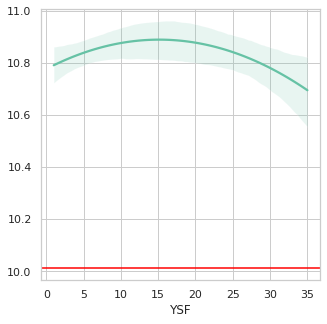

In [99]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.regplot(dfp, x="YSF", y="rh_70", scatter=False, y_partial="pre_fire_ndvi", order=2)
ax.axhline(unburned.rh_70.mean(), color="red")

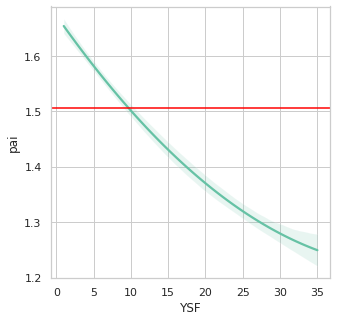

In [100]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.regplot(dfp, x="YSF", y="pai", scatter=False, order=2)
ax.axhline(unburned.pai.mean(), color="red")

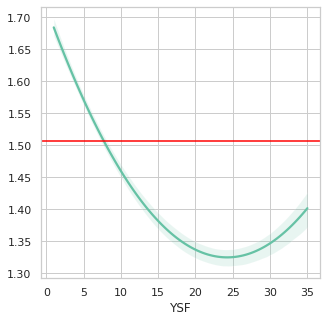

In [101]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.regplot(dfp, x="YSF", y="pai", scatter=False, y_partial="slope", order=2)
ax.axhline(unburned.pai.mean(), color="red")

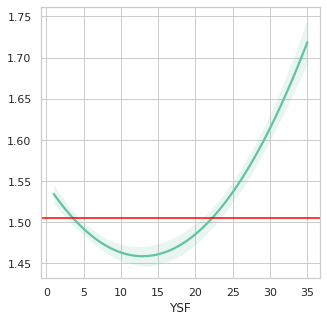

In [102]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.regplot(dfp, x="YSF", y="pai", scatter=False, y_partial="pre_fire_ndvi", order=2)
ax.axhline(unburned.pai.mean(), color="red")

## Modeling

In [106]:
dfp = burned[burned.severity == 2][["slope", "pre_fire_ndvi", "ndvi", "YSF", "elevation", "dnbr_mean", "fire_size_acres", "latitude", "longitude", "pai"]].dropna()

In [136]:
x = dfp.slope.to_numpy()
a = dfp.pre_fire_ndvi.to_numpy()
b = dfp.YSF.to_numpy()
c = dfp.elevation.to_numpy()
d = dfp.dnbr_mean.to_numpy()
e = dfp.fire_size_acres.to_numpy()
f= dfp.latitude.to_numpy()
g = dfp.longitude.to_numpy()

In [137]:
y = dfp.pai.to_numpy()
X = sm.add_constant(np.stack([x, a, b**2]).T)

In [138]:
model = sm.OLS(y, X)
m = model.fit()
print(m.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.126
Method:                 Least Squares   F-statistic:                 1.846e+04
Date:                Wed, 24 Jan 2024   Prob (F-statistic):               0.00
Time:                        04:32:43   Log-Likelihood:            -6.1959e+05
No. Observations:              383240   AIC:                         1.239e+06
Df Residuals:                  383236   BIC:                         1.239e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.4827      0.013   -116.538      0.0